# Airbnb Property Price Predictor
- **Project Scope:** To develop (train and fine tune) a Regression model to predict the overnight price of a Airbnb property in Cape Town
- **Data:** listings.csv file containing columns: ('id', 'name', 'host_id', 'host_name', 'neighbourhood_group','neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license')
- **Approach:** We will Explore, Preprocess the data, train, fine-tune and evaluate at least two models, select the best performing model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## Exploration
- **Steps:** Read the data in, Explore the data to get insights
- **Insights:** - Duplicates: no duplicated rows
                  - Nulls: Some columns contain nulls, must be handled
Completely empty cols: 'neighbourhood_group', 'license' (Drop)

Partially empty cols: 'reviews_per_month', 'last_review' (impute)
'price' (Drop nulls as imputing would impact predictions)

Columns with no correlation with the target variable: 'id', 'name', 'host_id', 'host_name' (Drop)

In [2]:
data = pd.read_csv(r"C:\Users\Lenovo\Downloads\listings.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,3191,Malleson Garden Cottage,3754,Brigitte,NaN,Ward 57,-33.947620,18.475990,Entire home/apt,783.0,3,79,2024-06-18,0.56,1,11,4,NaN
1,15007,Blaauwberg House on the beach in Bloubergstrand,59072,Dirk,NaN,Ward 23,-33.800010,18.460630,Entire home/apt,6550.0,2,47,2024-10-19,0.35,3,46,2,NaN
2,15068,Grande Bay,59318,Linda,NaN,Ward 23,-33.788260,18.459400,Entire home/apt,3000.0,4,0,NaN,NaN,6,356,0,NaN
3,15077,Relaxed beach living in style,59342,Georg,NaN,Ward 4,-33.858356,18.490376,Private room,2165.0,2,7,2022-06-16,0.05,6,90,0,NaN
4,15199,Self catering apartment,59694,Alexa,NaN,Ward 115,-33.911150,18.412350,Entire home/apt,2500.0,14,2,2016-04-15,0.02,1,365,0,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25816 entries, 0 to 25815
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25816 non-null  int64  
 1   name                            25815 non-null  object 
 2   host_id                         25816 non-null  int64  
 3   host_name                       25745 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   25816 non-null  object 
 6   latitude                        25816 non-null  float64
 7   longitude                       25816 non-null  float64
 8   room_type                       25816 non-null  object 
 9   price                           21510 non-null  float64
 10  minimum_nights                  25816 non-null  int64  
 11  number_of_reviews               25816 non-null  int64  
 12  last_review                     

In [4]:
data.describe().round()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.581600e+04,25816.0,0.0,25816.0,25816.0,21510.0,25816.0,25816.0,19458.0,25816.0,25816.0,25816.0
mean,5.871331e+17,204091767.0,NaN,-34.0,18.0,4404.0,4.0,23.0,1.0,13.0,200.0,6.0
std,5.316011e+17,200048389.0,NaN,0.0,0.0,9540.0,21.0,46.0,1.0,28.0,130.0,11.0
min,3.191000e+03,3754.0,NaN,-34.0,18.0,144.0,1.0,0.0,0.0,1.0,0.0,0.0
25%,3.258190e+07,34914033.0,NaN,-34.0,18.0,1200.0,1.0,1.0,0.0,1.0,75.0,0.0
50%,7.337961e+17,116051353.0,NaN,-34.0,18.0,2129.0,2.0,5.0,1.0,2.0,238.0,2.0
75%,1.086186e+18,370727208.0,NaN,-34.0,18.0,4071.0,3.0,24.0,1.0,8.0,320.0,8.0
max,1.320402e+18,668818957.0,NaN,-34.0,19.0,273736.0,999.0,798.0,23.0,175.0,365.0,154.0


In [5]:
data.duplicated().sum()

np.int64(0)

In [6]:
nulls = []

for col in data.columns:
    null_count = data[col].isnull().sum()
    percentage = null_count / len(data) * 100
    nulls.append({
        'column': col,
        'nulls': null_count,
        'percentage': round(percentage, 2)})

nulls_df = pd.DataFrame(nulls)

nulls_df = nulls_df.sort_values(by='percentage', ascending=False)

nulls_df.head(7)

,column,nulls,percentage
4,neighbourhood_group,25816,100.00
17,license,25732,99.67
13,reviews_per_month,6358,24.63
12,last_review,6358,24.63
9,price,4306,16.68
3,host_name,71,0.28
1,name,1,0.00


<Axes: >

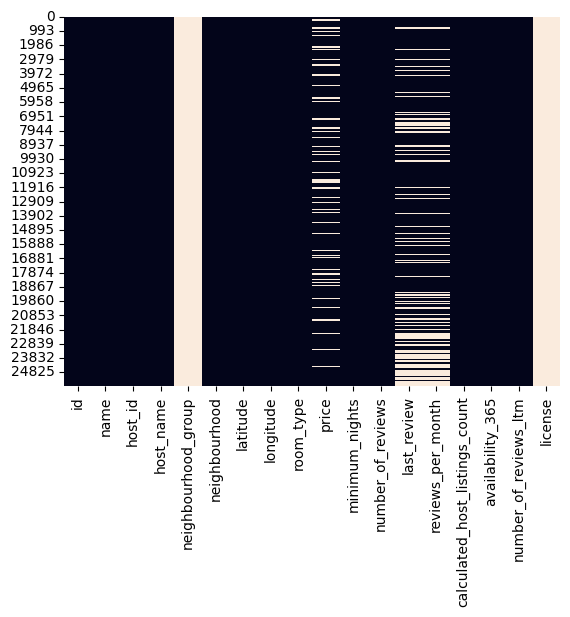

In [7]:
sns.heatmap(data.isnull(), cbar=False)

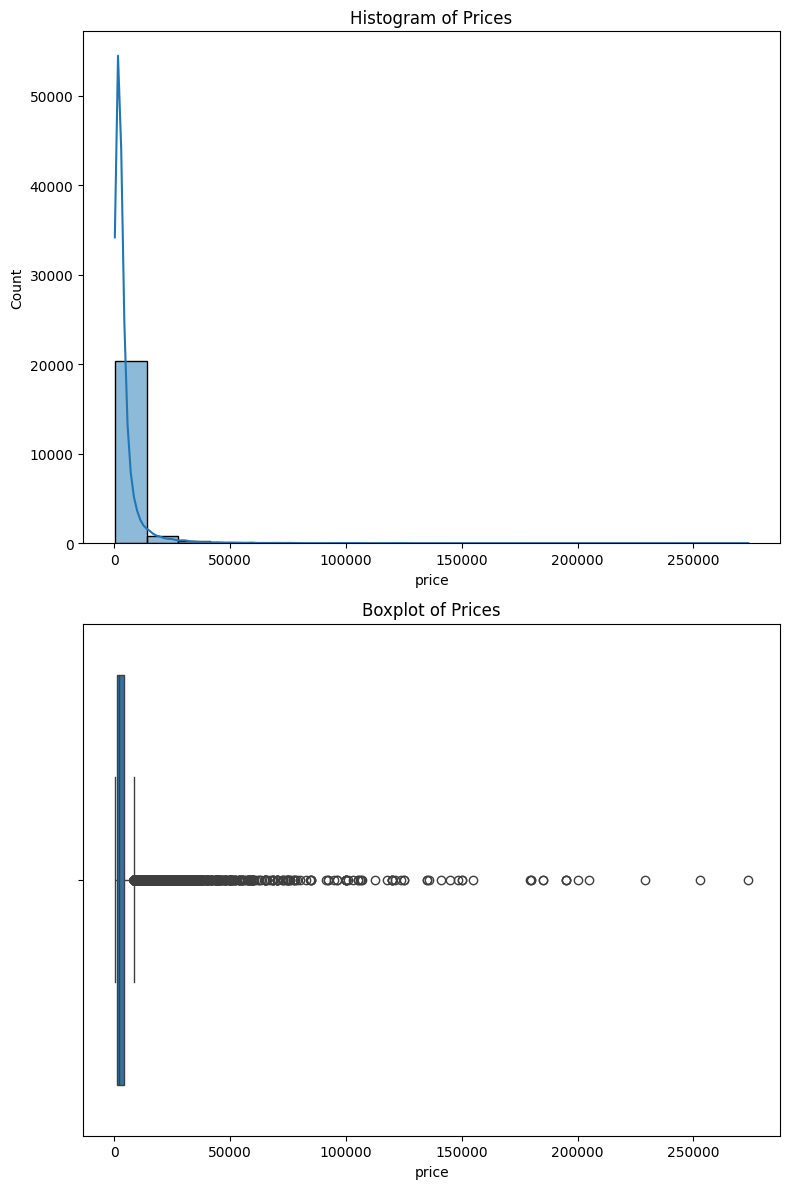

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12)) 

sns.histplot(data["price"], bins=20, kde=True, ax=ax[0])
ax[0].set_title("Histogram of Prices")

sns.boxplot(x=data["price"], ax=ax[1])
ax[1].set_title("Boxplot of Prices")

plt.tight_layout()
plt.show()

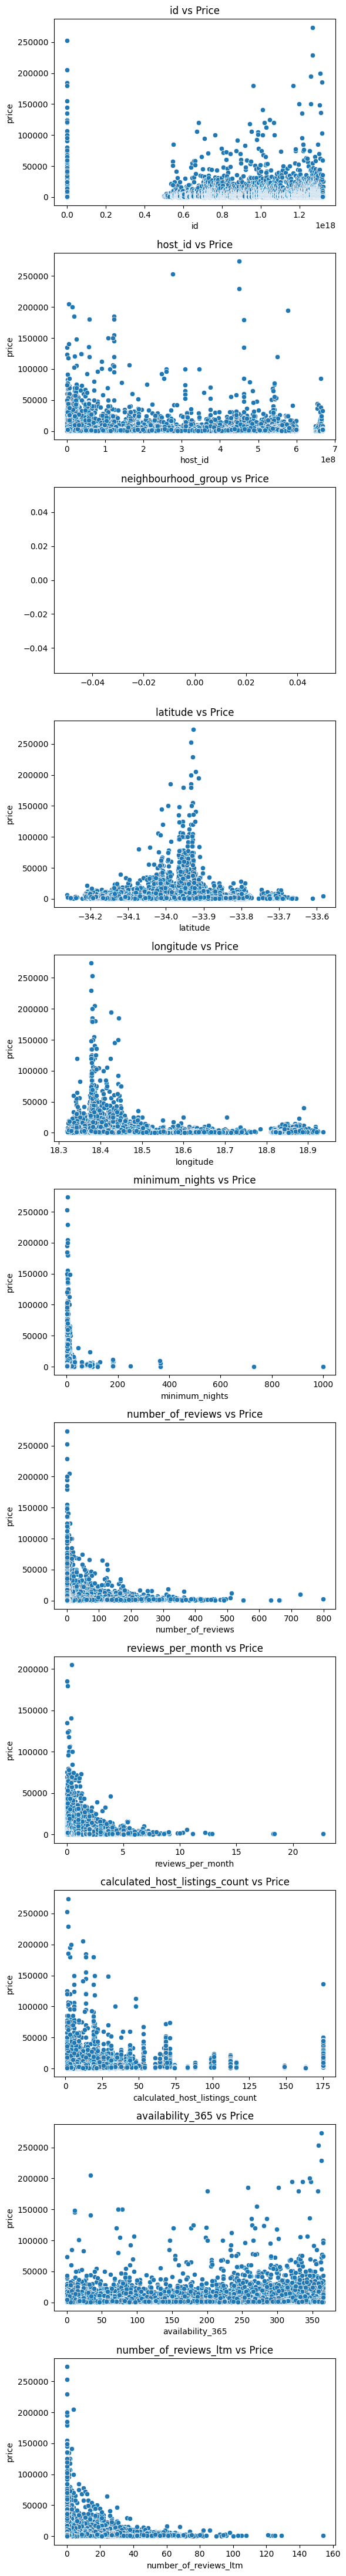

In [9]:
correlations = data.corr(numeric_only=True)["price"].sort_values(ascending=False)
numeric_cols = data.select_dtypes(include='number').columns.drop("price")

fig, axs = plt.subplots(len(numeric_cols), 1, figsize=(6, 4 * len(numeric_cols)))

for ax, col in zip(axs, numeric_cols):
    sns.scatterplot(x=col, y="price", data=data, ax=ax)
    ax.set_title(f"{col} vs Price")

plt.tight_layout()
plt.show()

## Preprocessing
- Handle nulls:'neighbourhood_group', 'license' (Drop); 'reviews_per_month', 'last_review' (impute) 'price' (Drop nulls as imputing would impact predictions)
Columns with no correlation with the target variable: 'id', 'name', 'host_id', 'host_name' (Drop)

Fix formatting: 'neighbourhood' (Trim to convert to numeric); 'room_type', 'last_review_missing' (encode)

Handle outliers: 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count' (Cap outliers)

In [10]:
data_ = data.copy()

In [11]:
data = data_.copy()

In [12]:
data = data.drop(columns=['neighbourhood_group', 'license', 'id', 'name', 'host_id', 'host_name'] )

In [13]:
data = data.dropna(subset=['price'])

In [14]:
data['last_review'] = pd.to_datetime(data['last_review'])

data['last_review_missing'] = data['last_review'].isna()  # a column to flag missing reviews

data['last_review'] = data['last_review'].fillna(data['last_review'].mean())

In [15]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(data['reviews_per_month'].mean())

In [16]:
data['neighbourhood'] = pd.to_numeric(data['neighbourhood'].str[5:], errors='coerce')

In [17]:
rt_dummies = pd.get_dummies(data['room_type'], prefix='room_type', drop_first=False)

data = pd.concat([data, rt_dummies], axis=1)

data = data.drop(columns=['room_type'])

In [18]:
cols =['last_review_missing',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room']

data[cols] = data[cols].astype(int)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21510 entries, 0 to 25815
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   neighbourhood                   21510 non-null  int64         
 1   latitude                        21510 non-null  float64       
 2   longitude                       21510 non-null  float64       
 3   price                           21510 non-null  float64       
 4   minimum_nights                  21510 non-null  int64         
 5   number_of_reviews               21510 non-null  int64         
 6   last_review                     21510 non-null  datetime64[ns]
 7   reviews_per_month               21510 non-null  float64       
 8   calculated_host_listings_count  21510 non-null  int64         
 9   availability_365                21510 non-null  int64         
 10  number_of_reviews_ltm           21510 non-null  int64         
 11  last_re

In [20]:
data.describe().round()

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,last_review_missing,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
count,21510.0,21510.0,21510.0,21510.0,21510.0,21510.0,21510,21510.0,21510.0,21510.0,21510.0,21510.0,21510.0,21510.0,21510.0,21510.0
mean,72.0,-34.0,18.0,4404.0,4.0,26.0,2024-06-08 11:58:24.953321216,1.0,14.0,228.0,7.0,0.0,1.0,0.0,0.0,0.0
min,1.0,-34.0,18.0,144.0,1.0,0.0,2014-11-17 00:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,54.0,-34.0,18.0,1200.0,1.0,1.0,2024-06-08 11:58:24.953321216,0.0,1.0,136.0,0.0,0.0,1.0,0.0,0.0,0.0
50%,64.0,-34.0,18.0,2129.0,2.0,7.0,2024-09-24 00:00:00,1.0,2.0,263.0,2.0,0.0,1.0,0.0,0.0,0.0
75%,107.0,-34.0,18.0,4071.0,3.0,28.0,2024-12-09 00:00:00,1.0,10.0,327.0,9.0,0.0,1.0,0.0,0.0,0.0
max,116.0,-34.0,19.0,273736.0,999.0,798.0,2024-12-28 00:00:00,23.0,175.0,365.0,154.0,1.0,1.0,1.0,1.0,1.0
std,32.0,0.0,0.0,9540.0,14.0,49.0,NaN,1.0,30.0,113.0,11.0,0.0,0.0,0.0,0.0,0.0


In [21]:
data.columns

Index(['neighbourhood', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'last_review_missing',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

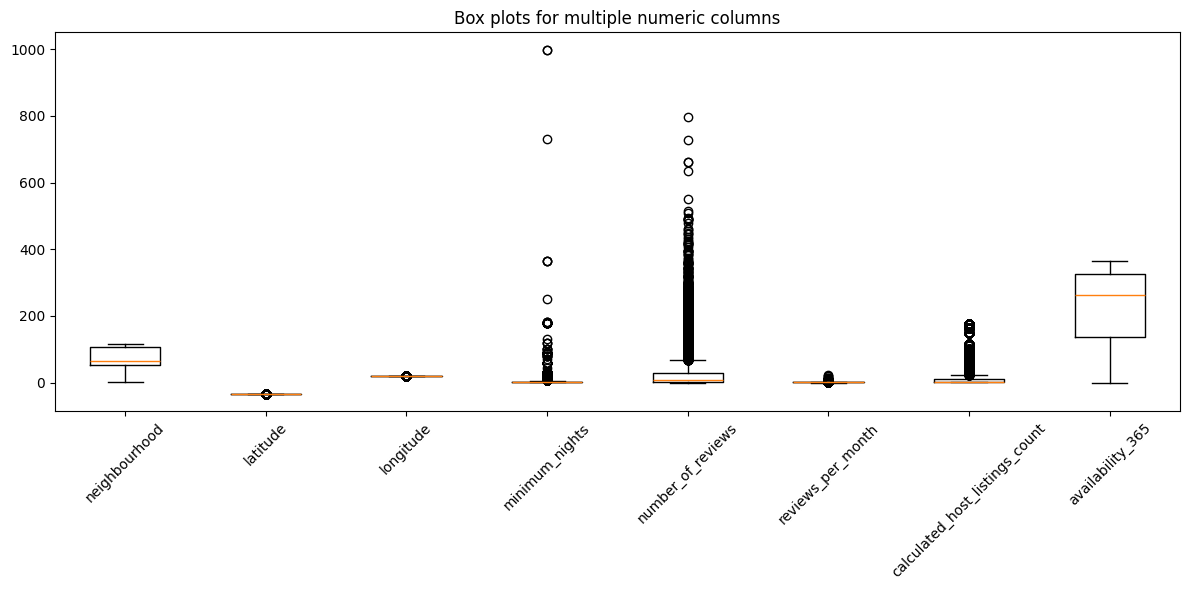

In [22]:
cols = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']


plt.figure(figsize=(12, 6))
plt.boxplot([data[col] for col in cols], tick_labels=cols)
plt.title('Box plots for multiple numeric columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
def handle_outliers(col, data):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [24]:
cols = ['latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count']

for col in cols:
    data = handle_outliers(col, data)

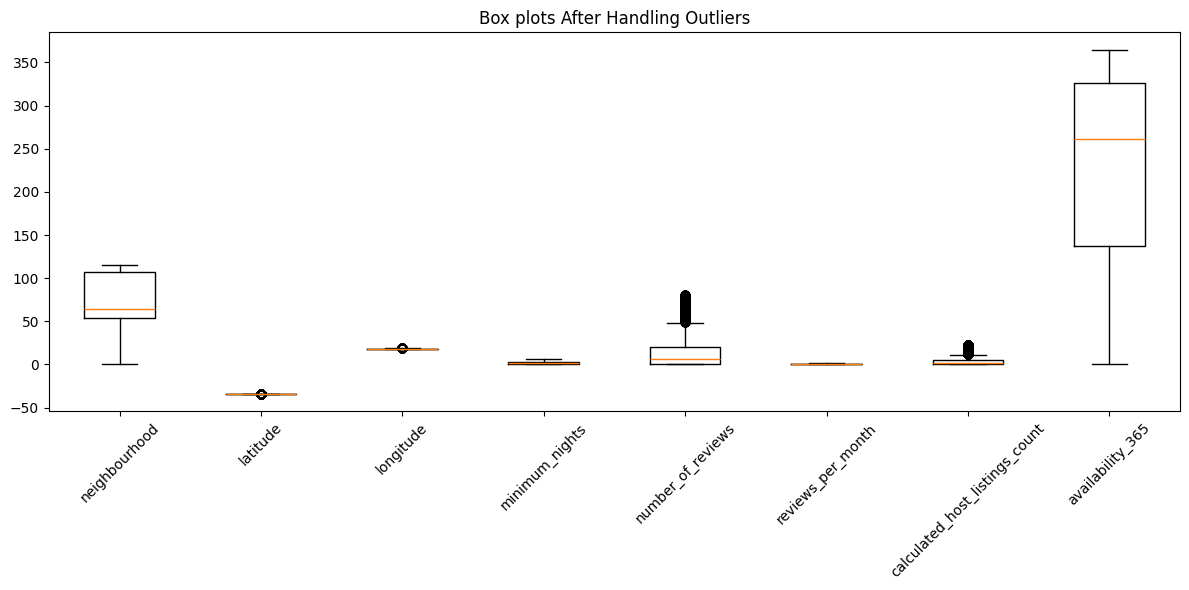

In [25]:
cols = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']


plt.figure(figsize=(12, 6))
plt.boxplot([data[col] for col in cols], tick_labels=cols)
plt.title('Box plots After Handling Outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model Training
Base line model to this model’s performance (R², MAE) to the actual model

The model is not overfitting, as its performance on the training set (1527.36) is reasonably close to its performance on the test set (1627.78)

Underfittting: the model is not underfitting as the training error is not high and decreases with fine-tuning

Finetuning: the RMSE (training and test) decreased significantly after fine-tuning. This means the model is fitting the training and testing data better no

In [26]:
data__ = data.copy()

In [27]:
data = data__.copy()

In [28]:
y = data['price']  # target variable
X = data.drop(columns=['price'])  # features
X = X.select_dtypes(exclude=['datetime64[ns]', 'datetime64'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model 1: Linear regressor

model 2: GradientBoosting regressor

model 3: RandomForest regressor

In [29]:
models = {"Linear Regression": LinearRegression(),
          "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
          "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)}

rmse_list = []
std_list = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -scores
    rmse_list.append(np.mean(rmse))
    std_list.append(np.std(rmse))
    print(f"{name}: Mean RMSE = {np.mean(rmse):.2f}, Std = {np.std(rmse):.2f}")

Linear Regression: Mean RMSE = 1680.06, Std = 51.29
Gradient Boosting: Mean RMSE = 1615.28, Std = 50.91
Random Forest: Mean RMSE = 1624.89, Std = 61.38


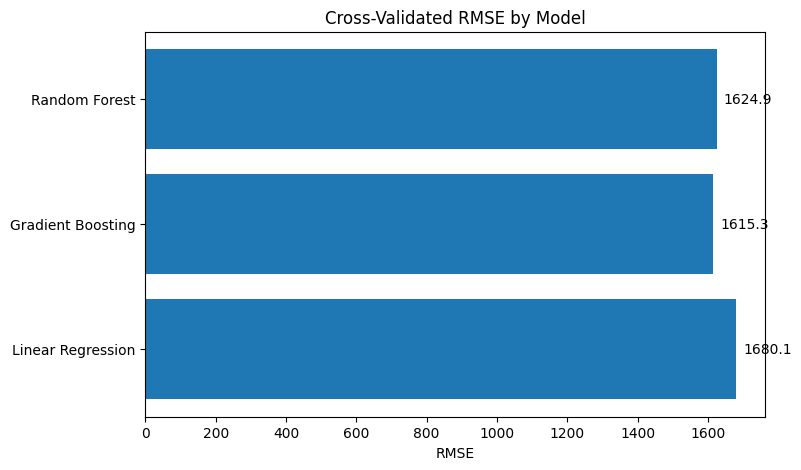

In [30]:
plt.figure(figsize=(8,5))
bars = plt.barh(models.keys(), rmse_list, capsize=5)
for bar, rmse in zip(bars, rmse_list):
    width = bar.get_width()
    plt.text(width + 20, bar.get_y() + bar.get_height() / 2, f'{rmse:.1f}',
             va='center', fontsize=10)
plt.xlabel('RMSE')
plt.title('Cross-Validated RMSE by Model')
plt.show()

Gradient Boosting performs better than the other 2 models

In [31]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_train = gbr.predict(X_train)
y_pred_before = gbr.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_before = np.sqrt(mean_squared_error(y_test, y_pred_before))

print("rmse_train:", rmse_train)
print("rmse_before:", rmse_before)

rmse_train: 1527.3632406965341
rmse_before: 1627.7775255149133



Randomized Search 

In [32]:
param_dist = {'n_estimators': [50, 100, 200, 300],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [3, 4, 5, 6],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'subsample': [0.6, 0.8, 1.0],
              'max_features': ['sqrt', 'log2', None]}

r_s = RandomizedSearchCV(estimator=gbr,
                         param_distributions=param_dist,
                         n_iter=10,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         verbose=2,
                         random_state=42,
                         n_jobs=-1)

r_s.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [33]:
X_train.columns

Index(['neighbourhood', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'last_review_missing',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

In [34]:
best_model = r_s.best_estimator_
y_pred_after = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_after = np.sqrt(mean_squared_error(y_test, y_pred_after))

print("rmse_train:", rmse_train)
print("rmse_after:", rmse_after)

rmse_train: 1334.7763534319915
rmse_after: 1603.5527633640756


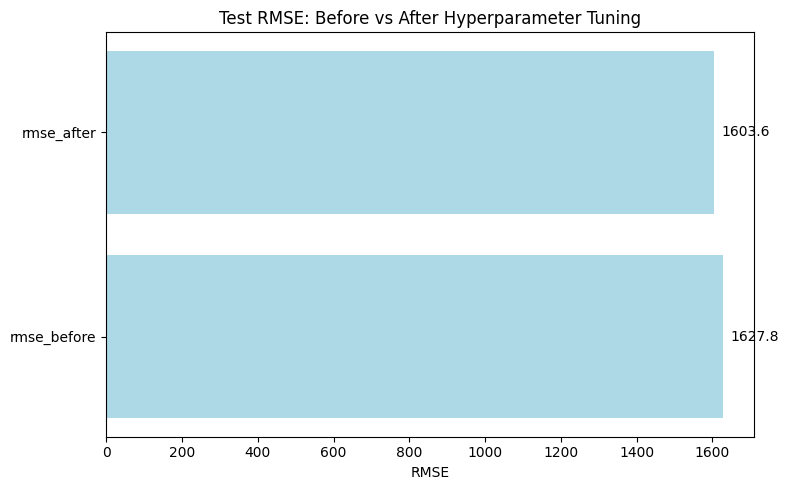

In [35]:
rmses = {'rmse_before': rmse_before, 'rmse_after': rmse_after}

plt.figure(figsize=(8, 5))
bars = plt.barh(list(rmses.keys()), list(rmses.values()), capsize=5, color='lightblue')

for bar, value in zip(bars, rmses.values()):
    width = bar.get_width()
    plt.text(width + 20, bar.get_y() + bar.get_height() / 2,
             f'{value:.1f}', va='center', fontsize=10)

plt.xlabel('RMSE')
plt.title('Test RMSE: Before vs After Hyperparameter Tuning')
plt.tight_layout()
plt.show()

After Hyperparameter fine-tuning, performance improved from an error of R1627,8 to R1603,6

## Erro Analysis

In [36]:
data.columns

Index(['neighbourhood', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'last_review_missing',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

In [37]:
df = pd.DataFrame({
    'y_true': y_test,            
    'y_pred': best_model.predict(X_test),  
    'neighbourhood': X_test['neighbourhood'],
    'minimum_nights': X_test['minimum_nights'],
    'availability_365': X_test['availability_365'],
    'reviews_per_month': X_test['reviews_per_month']})

df['abs_error'] = np.abs(df['y_true'] - df['y_pred'])
df['perc_error'] = df['abs_error'] / np.abs(df['y_true']) * 100  

features = ['neighbourhood', 'minimum_nights', 'reviews_per_month', 'availability_365']

print("The feature values with the highest errors")
for i in features:
    error_ = df.groupby(i)[['abs_error', 'perc_error']].mean().sort_values(by='abs_error', ascending=False)
    print(error_.head(3))

The feature values with the highest errors
                 abs_error  perc_error
neighbourhood                         
27             2144.142850   49.341651
62             1643.530979   88.401576
54             1502.926456   55.935001
                  abs_error  perc_error
minimum_nights                         
4               1634.093524   74.306736
6               1611.824366   85.003389
5               1467.136569   55.931734
                     abs_error  perc_error
reviews_per_month                         
1.93               5634.989980   74.605984
1.19               2834.332110   50.174362
1.90               2780.317418   51.533454
                    abs_error  perc_error
availability_365                         
77                3860.926435   65.439431
68                3247.006934   97.739238
143               3173.537371   52.444515


In [38]:
importances = best_model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df.sort_values('importance', ascending=False, inplace=True)
importance_df.tail()

,feature,importance
5,reviews_per_month,0.050465
8,number_of_reviews_ltm,0.040470
9,last_review_missing,0.010707
11,room_type_Hotel room,0.001633
13,room_type_Shared room,0.000438


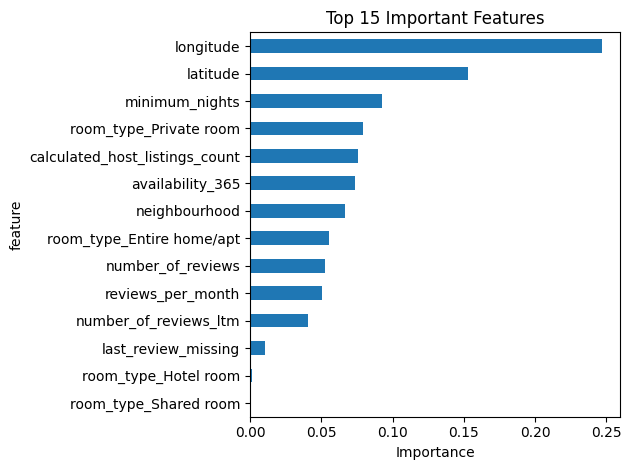

In [39]:
importance_df.head(15).plot(kind='barh', x='feature', y='importance', legend=False)
plt.title(f'Top 15 Important Features')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Dump the model

In [40]:
import joblib

In [41]:
feature_means = X_train.mean().to_dict()
joblib.dump(feature_means, 'feature_means.pkl')

['feature_means.pkl']

In [42]:
joblib.dump(best_model, 'gbr_model.pkl')

['gbr_model.pkl']